In [1]:
import os
import uuid
import numpy as np
import librosa
import librosa.display
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from modules.PostgresDBHandler import PostgresDBHandler

In [2]:
base_dir = "./"
intermediate_dir = "intermediate_results"
fixedLength = 128
dbParams = {
    "dbname": "mydatabase",
    "user": "postgres",
    "password": "79eRReroWY",
    "host": "localhost",
    "port": "5432",
}

In [3]:
os.makedirs(os.path.join(intermediate_dir, "melSpectrogram"), exist_ok=True)
os.makedirs(os.path.join(intermediate_dir, "mfcc"), exist_ok=True)

# Augmentacja

In [4]:
def pad_or_truncate(array, fixed_length):
    if array.shape[1] > fixed_length:
        return array[:, :fixed_length]
    elif array.shape[1] < fixed_length:
        pad_width = fixed_length - array.shape[1]
        return np.pad(array, ((0, 0), (0, pad_width)), mode="constant")
    else:
        return array

In [5]:
def augment_audio(audio_data, sr):

    # Time-stretching
    stretched = librosa.effects.time_stretch(audio_data, rate=1.1)

    # Pitch-shifting
    pitched = librosa.effects.pitch_shift(audio_data, sr=sr, n_steps=2)

    # Adding noise
    noise = np.random.randn(len(audio_data))
    audio_data_noisy = audio_data + 0.005 * noise

    # Ensure all augmented data have the same dtype
    audio_data_noisy = audio_data_noisy.astype(np.float32)
    stretched = stretched.astype(np.float32)
    pitched = pitched.astype(np.float32)
    
    augmented_data = {
        "time_stretch": stretched,
        "pitch_shifting": pitched,
        "noise": audio_data_noisy,
    }

    return augmented_data

In [6]:
def preprocess_audio(audio_data, sr):
    if audio_data.ndim > 1:
        audio_data = librosa.to_mono(audio_data)

    audio_data = librosa.util.normalize(audio_data)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    mfccs = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=13)

    return mel_spectrogram_db, mfccs

In [7]:
def process_file(audio_index, db_params):
    db = PostgresDBHandler(**db_params)
    db.connect()

    db_data = db.get_audio_file(audio_index)
    audio, _ = librosa.load(db_data['filePath'], sr=db_data["sampleRate"])

    # Preprocess original audio
    mel_spectrogram, mfcc = preprocess_audio(audio, db_data["sampleRate"])

    unique_id = uuid.uuid4()
    mel_spectrogram_path = (
        os.path.join(intermediate_dir, "melSpectrogram", f"{unique_id}_mel.npy")
    )
    mfcc_path = os.path.join(intermediate_dir, "mfcc", f"{unique_id}_mfcc.npy")


    np.save(mel_spectrogram_path, pad_or_truncate(mel_spectrogram, fixedLength))
    np.save(mfcc_path, pad_or_truncate(mfcc, fixedLength))

    db.insert_processed_audio(
        db_data["instrumentID"],
        db_data["audioID"],
        fixedLength,
        mel_spectrogram_path,
        mfcc_path,
        "original",
    )

    # Apply data augmentation
    augmented_audios = augment_audio(audio, db_data["sampleRate"])
    for key in augmented_audios:
        mel_spectrogram, mfcc = preprocess_audio(
            augmented_audios[key], db_data["sampleRate"]
        )

        unique_id = uuid.uuid4()
        mel_spectrogram_path = (
            os.path.join(intermediate_dir, "melSpectrogram", f"{unique_id}_mel.npy")
        )
        mfcc_path = os.path.join(intermediate_dir, "mfcc", f"{unique_id}_mfcc.npy")

        np.save(mel_spectrogram_path, pad_or_truncate(mel_spectrogram, fixedLength))
        np.save(mfcc_path, pad_or_truncate(mfcc, fixedLength))

        db.insert_processed_audio(
            db_data["instrumentID"],
            db_data["audioID"],
            fixedLength,
            mel_spectrogram_path,
            mfcc_path,
            key,
        )
    db.close()

In [8]:
def apply_preprocessing_with_augmentation(audios_ids, db_params, n_jobs=-1):
    Parallel(n_jobs=n_jobs)(
        delayed(process_file)(audio_index, db_params) for audio_index in audios_ids
    )

In [9]:
db = PostgresDBHandler(**dbParams)
db.connect()
audio_ids = db.get_all_audio_ids()
print(len(audio_ids))
db.close()

16310


In [10]:
# audio_ids = audio_ids[:10]

In [11]:
apply_preprocessing_with_augmentation(audio_ids, dbParams)

In [12]:
def plot_spectrogram(spectrogram, sr=22050):
    # Plot the spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spectrogram, sr=sr, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()

In [13]:
def plot_mfcc(mfcc):
    # Plot the MFCC
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfcc, x_axis="time")
    plt.colorbar()
    plt.title("MFCC")
    plt.tight_layout()
    plt.show()

In [14]:
db = PostgresDBHandler(**dbParams)
db.connect()
processed = db.get_processed_audio(100)
db.close()

In [15]:
processed

{'processedID': 100,
 'instrumentID': 8,
 'audioID': 23,
 'fixedLength': 128,
 'spectrogramPath': 'intermediate_results\\melSpectrogram\\cd3152a0-67f1-49a5-bf56-dcbd38ab66a3_mel.npy',
 'mfccPath': 'intermediate_results\\mfcc\\cd3152a0-67f1-49a5-bf56-dcbd38ab66a3_mfcc.npy',
 'augmentation': 'noise'}

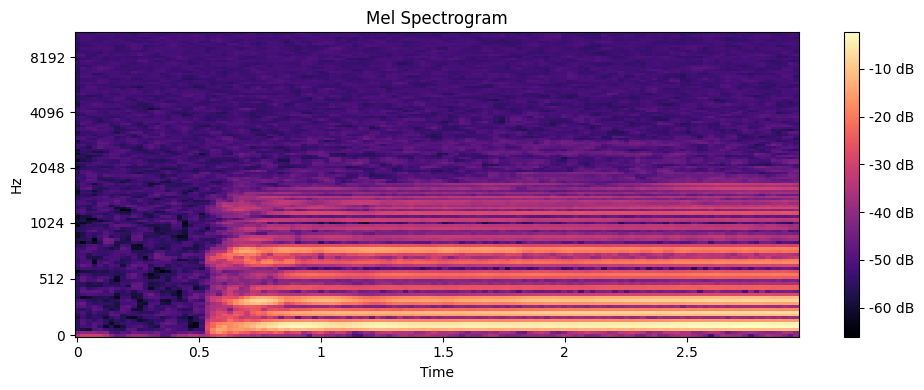

In [16]:
plot_spectrogram(np.load(processed["spectrogramPath"]))

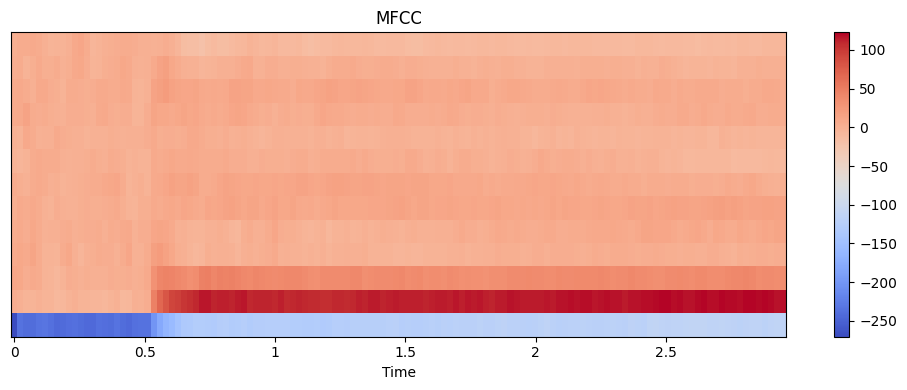

In [17]:
plot_mfcc(np.load(processed["mfccPath"]))